In [3]:
# Prices
print("Loading prices data...")
url = 'https://drive.google.com/uc?id=1P_5ykYLd5521QUdCxC_cMytdJ3PqESTw'
prices = pd.read_csv(url, parse_dates=True, index_col=0)
print("✓ Loaded prices")

Loading prices data...
✓ Loaded prices


In [4]:
!pip install hmmlearn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\diouf\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
prices.head(10)

,coin,open,high,low,close,volume
date,,,,,,
2018-01-01 01:00:00,BTC,13791.4,13804.9,13680.0,13680.0,5.922596
2018-01-01 02:00:00,BTC,13500.4,13600.0,13480.0,13514.0,9.326084
2018-01-01 03:00:00,BTC,13512.0,13576.4,13512.0,13560.2,11.704644
2018-01-01 04:00:00,BTC,13694.8,13809.8,13667.4,13667.4,17.126073
2018-01-01 05:00:00,BTC,13763.3,13887.9,13658.6,13765.0,9.322753
2018-01-01 06:00:00,BTC,13781.2,13849.4,13747.0,13747.0,26.133538
2018-01-01 07:00:00,BTC,14108.4,14224.0,14099.0,14168.7,12.534892
2018-01-01 08:00:00,BTC,13950.1,14120.4,13901.1,13922.1,9.495752
2018-01-01 09:00:00,BTC,13742.7,13884.0,13742.7,13785.0,6.781434


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.inspection import permutation_importance
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

## Feature Engineering

Technical and statistical features from hourly OHLCV data to capture price dynamics, momentum, volatility, volume, and cyclical behavior. Key features include:

**Returns & Volatility**: Log returns, rolling volatility, ATR.

**Trend & Momentum**: Moving averages, MACD, slope, momentum.

**Volume Metrics**: VWAP, OBV, volume change, dollar volume.

**Indicators**: RSI, Bollinger Bands, Z-score, CCI.

**Pattern Features**: Candle body, wick ratios.

**Seasonality**: Hour-of-day and day-of-week (cyclical encodings).

**Others**: Lagged returns, autocorrelation, illiquidity proxy.

In [7]:
def feature_engineer_hourly(hourly_df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate technical/statistical features from hourly OHLCV data.
    Input: df (DataFrame) with ['open', 'high', 'low', 'close', 'volume'] columns.
    Output: Feature-rich DataFrame with NaNs dropped.
    """

    df = hourly_df.copy()

    # --- Rename -------------------------------------------------------------
    df = df.rename(columns={
        "open": "Open", "high": "High",
        "low": "Low",  "close": "Close",
        "volume": "Volume"
    })

    # 1) Hourly log return
    df["LogReturn_1h"] = np.log(df["Close"] / df["Close"].shift(1))

    # 2) Moving-averages
    df["MA_6h"]  = df["Close"].rolling(6).mean()
    df["MA_12h"] = df["Close"].rolling(12).mean()
    df["MA_24h"] = df["Close"].rolling(24).mean()
    df["MA_168h"] = df["Close"].rolling(168).mean()

    # 3) EMAs & MACD
    df["EMA_6h"]  = df["Close"].ewm(span=6 , adjust=False).mean()
    df["EMA_12h"] = df["Close"].ewm(span=12, adjust=False).mean()
    df["EMA_26h"] = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD_12_26h"] = df["EMA_12h"] - df["EMA_26h"]
    df["Signal_9h"]   = df["MACD_12_26h"].ewm(span=9, adjust=False).mean()

    # 4) Momentum
    df["Momentum_6h"]    = df["Close"] - df["Close"].shift(6)
    df["MomentumPct_6h"] = df["Close"].pct_change(6)

    # 5) Volatility
    df["Volatility_6h"]  = df["LogReturn_1h"].rolling(6 ).std()
    df["Volatility_12h"] = df["LogReturn_1h"].rolling(12).std()

    # 6) RSI
    delta = df["Close"].diff()
    gain  = delta.clip(lower=0)
    loss  = -delta.clip(upper=0)
    rs14  = gain.rolling(14).mean() / loss.rolling(14).mean()
    rs30  = gain.rolling(30).mean() / loss.rolling(30).mean()
    df["RSI_14h"] = 100 - 100 / (1 + rs14)
    df["RSI_30h"] = 100 - 100 / (1 + rs30)

    # 7) Autocorr
    df["AutoCorr1_12h"] = (
        df["LogReturn_1h"].rolling(12).apply(lambda x: x.autocorr(1), raw=False)
    )
    df["AutoCorr1_24h"] = (
        df["LogReturn_1h"].rolling(24).apply(lambda x: x.autocorr(1), raw=False)
    )

    # 8) Lagged returns
    for lag in [1, 2, 3, 6, 12]:
        df[f"LagRet_{lag}h"] = df["LogReturn_1h"].shift(lag)

    # 9) ATR-14h
    hl = df["High"] - df["Low"]
    hc = (df["High"] - df["Close"].shift()).abs()
    lc = (df["Low"]  - df["Close"].shift()).abs()
    df["ATR_14h"] = pd.concat([hl, hc, lc], axis=1).max(axis=1).rolling(14).mean()

    # 10) Bollinger Bands
    ma20 = df["Close"].rolling(20).mean()
    sd20 = df["Close"].rolling(20).std()
    df["BB_Upper_20h"] = ma20 + 2 * sd20
    df["BB_Lower_20h"] = ma20 - 2 * sd20

    # 11) VWAP-24h
    pv = df["Close"] * df["Volume"]
    df["VWAP_24h"] = pv.rolling(24).sum() / df["Volume"].rolling(24).sum()

    # 12) OBV
    df["OBV"] = (np.sign(df["Close"].diff()) * df["Volume"]).fillna(0).cumsum()

    # 13) Z-score, CCI
    df["ZScore_20h"] = (df["Close"] - ma20) / sd20
    tp = (df["High"] + df["Low"] + df["Close"]) / 3
    cci_dev = tp.rolling(14).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    df["CCI_14h"] = (tp - tp.rolling(14).mean()) / (0.015 * cci_dev)

    # 14) Cleanup
    df = df.drop(columns=["EMA_26h"])        # helper cols

    # 15) Slope over 6h window (trend strength)
    def get_slope(series):
        x = np.arange(len(series))
        x = sm.add_constant(x)
        model = sm.OLS(series.values, x).fit()
        return model.params[1]

    df["Slope_6h"] = df["Close"].rolling(6).apply(get_slope, raw=False)

    # 16) Log high-low ratio (range strength)
    df["LogHL"] = np.log(df["High"]) - np.log(df["Low"])

    # 17) Volatility-adjusted return (instantaneous Sharpe)
    df["Sharpe_6h"] = df["Momentum_6h"] / df["Volatility_6h"]

    # 18) Rolling volume percentile (over 24h window)
    df["VolRank_24h"] = (
        df["Volume"].rolling(24)
        .apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1], raw=False)
    )

    # 19) Candle body size and wick ratio (pattern strength)
    df["CandleBody"] = np.abs(df["Close"] - df["Open"])
    df["UpperWick"] = df["High"] - df[["Close", "Open"]].max(axis=1)
    df["LowerWick"] = df[["Close", "Open"]].min(axis=1) - df["Low"]
    df["WickToBody"] = (df["UpperWick"] + df["LowerWick"]) / df["CandleBody"].replace(0, np.nan)

    # 20) Time of day and day of week (cyclical features)
    df["Hour"] = df.index.hour
    df["Hour_sin"] = np.sin(2 * np.pi * df["Hour"] / 24)
    df["Hour_cos"] = np.cos(2 * np.pi * df["Hour"] / 24)

    df["DayOfWeek"] = df.index.dayofweek
    df["DoW_sin"] = np.sin(2 * np.pi * df["DayOfWeek"] / 7)
    df["DoW_cos"] = np.cos(2 * np.pi * df["DayOfWeek"] / 7)

    # Drop helper cols
    df = df.drop(columns=["Hour", "DayOfWeek"])
    # 21) Volume change rate (volatility in volume)
    df["Volume_Change_1h"] = df["Volume"].pct_change()
    df["Volume_Change_6h"] = df["Volume"].pct_change(6)

    # 22) Rolling dollar volume (proxy for liquidity)
    df["DollarVolume_6h"] = (df["Close"] * df["Volume"]).rolling(6).mean()
    df["DollarVolume_24h"] = (df["Close"] * df["Volume"]).rolling(24).mean()

    # 23) High-Low Close Spread (proxy for illiquidity or manipulation)
    df["HL_Close_Spread"] = (df["High"] - df["Low"]) / df["Close"]


    df = df.dropna()

    print("feature_engineer_hourly:", df.shape)
    return df



### Regime Features 

**GMM Regime**: Gaussian Mixture Model applied on LogReturn_1h and Volatility_6h to cluster observations into discrete market regimes.

**HMM Regime**: Hidden Markov Model fitted on LogReturn_1h to identify unobserved regimes driving return dynamics.

In [8]:
def add_gmm_regime_feature(df: pd.DataFrame, n_states=3) -> pd.DataFrame:
    gmm = GaussianMixture(n_components=n_states, random_state=42)
    X = df[["LogReturn_1h", "Volatility_6h"]].dropna()
    gmm.fit(X)
    regimes = gmm.predict(X)
    df.loc[X.index, "GMM_Regime"] = regimes.astype(int)
    return df


def add_hmm_regime_feature(df: pd.DataFrame, n_states=3) -> pd.DataFrame:
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    returns = df["LogReturn_1h"].dropna().values.reshape(-1, 1)
    hmm.fit(returns)
    hidden_states = hmm.predict(returns)

    # Shift index to align
    state_series = pd.Series(hidden_states, index=df.dropna().index[-len(hidden_states):])
    df.loc[state_series.index, "HMM_Regime"] = state_series.astype(int)
    return df

In [9]:
features = feature_engineer_hourly(prices)
features = add_hmm_regime_feature(features)
features = add_gmm_regime_feature(features)
features.head()

feature_engineer_hourly: (53915, 52)


,coin,Open,High,Low,Close,Volume,LogReturn_1h,MA_6h,MA_12h,MA_24h,...,Hour_cos,DoW_sin,DoW_cos,Volume_Change_1h,Volume_Change_6h,DollarVolume_6h,DollarVolume_24h,HL_Close_Spread,HMM_Regime,GMM_Regime
date,,,,,,,,,,,,,,,,,,,,,
2018-01-08 00:00:00,BTC,16116.9,16116.9,15997.1,15997.1,13.768475,-0.024008,16151.983333,16215.641667,16456.008333,...,1.000000,0.0,1.0,0.516800,-0.809453,166117.601423,298872.271540,0.007489,1.0,1.0
2018-01-08 01:00:00,BTC,15822.0,15858.6,15696.4,15696.4,23.151223,-0.018976,16084.616667,16155.491667,16405.791667,...,0.965926,0.0,1.0,0.681466,0.660802,189276.253332,306849.909000,0.010334,1.0,1.0
2018-01-08 02:00:00,BTC,15674.0,15780.0,15674.0,15758.1,17.984457,0.003923,16026.666667,16098.391667,16358.004167,...,0.866025,0.0,1.0,-0.223175,1.278845,215325.454117,315785.987993,0.006727,0.0,1.0
2018-01-08 03:00:00,BTC,15687.9,15771.3,15680.0,15680.0,13.482318,-0.004969,15946.666667,16033.100000,16313.712500,...,0.707107,0.0,1.0,-0.250335,1.035794,232722.282735,320384.956983,0.005823,0.0,1.0
2018-01-08 04:00:00,BTC,15432.0,15610.0,15432.0,15610.0,25.024885,-0.004474,15854.566667,15971.441667,16273.512500,...,0.500000,0.0,1.0,0.856126,1.391253,269637.951809,327300.522764,0.011403,0.0,1.0


## Trend Labeling

In [10]:

def tValLinR_hourly(close):
    """
    Linear regression slope t-stat for hourly price segments.
    """
    x = np.ones((len(close), 2))
    x[:, 1] = np.arange(len(close))
    ols = sm.OLS(close, x).fit()
    return ols.tvalues[1], ols.params


For each timestamp, apply linear regression over multiple look-ahead horizons and compute the t-statistic of the slope. The horizon with the strongest trend (highest |t|) defines:

`t1`: End time of the detected trend window

`tVal`: Strength of the trend (t-statistic)

`bin`: Direction of the trend (+1 for up, -1 for down)

`windowSize`: Duration of the trend window (in hours)

In [11]:
def trend_labels_hourly(price_series, observation_span=(5, 20), look_forward=True):
    """
    Generate trend labels for hourly crypto price data.

    Parameters:
    - price_series: pd.Series of hourly prices
    - observation_span: (min, max) horizon range in hours
    - look_forward: whether to look into the future (True) or past (False)

    Returns:
    - DataFrame: ['t1', 'tVal', 'bin', 'windowSize']
    """
    out = pd.DataFrame(index=price_series.index, columns=['t1', 'tVal', 'bin', 'windowSize'])
    hrzns = range(*observation_span)
    n = len(price_series)

    for idx in price_series.index:
        iloc0 = price_series.index.get_loc(idx)
        if look_forward and iloc0 > n - observation_span[1]:
            continue
        if not look_forward and iloc0 < observation_span[1]:
            continue

        tval_dict = {}
        for h in hrzns:
            if look_forward:
                iloc_end = min(iloc0 + h, n - 1)
            else:
                iloc_end = max(iloc0 - h, 0)
            idx_range = slice(iloc0, iloc_end + 1) if look_forward else slice(iloc_end, iloc0 + 1)
            segment = price_series.iloc[idx_range]

            if len(segment) < 2:
                continue
            tval, _ = tValLinR_hourly(segment.values)
            tval_dict[h] = tval

        if not tval_dict:
            continue

        best_h = max(tval_dict, key=lambda x: abs(tval_dict[x]))
        best_tval = tval_dict[best_h]
        end_idx = min(iloc0 + best_h, n - 1) if look_forward else max(iloc0 - best_h, 0)
        out.loc[idx] = [
            price_series.index[end_idx],  # t1
            best_tval,                    # tVal
            np.sign(best_tval),          # bin
            best_h                        # windowSize
        ]

    out.dropna(subset=["bin"], inplace=True)

    # t-value bounding
    var = out["tVal"].var()
    tMax = min(20, var)
    out["tVal"] = out["tVal"].clip(lower=-tMax, upper=tMax)
    out["bin"] = out["bin"].astype(int)

    return out


*   Split into training (2018–2020) and test (2021) periods
*   Apply trend scanning to detect dominant price direction
*   Filter out neutral (0) signals

In [12]:
# 1. Extract hourly close prices
close_all = features["Close"]

# 2. Filter train and test sets
close_train = close_all.loc["2018-01-01":"2020-12-31"]
close_test  = close_all.loc["2021-01-01":"2021-12-31"]

# 3. Generate labels using trend scanning
labels_train = trend_labels_hourly(close_train, (5, 20), look_forward=True)
labels_test  = trend_labels_hourly(close_test, (5, 20), look_forward=True)

# 4. Filter non-neutral signals
labels_train = labels_train[labels_train["bin"] != 0]
labels_test  = labels_test[labels_test["bin"] != 0]


We align our feature matrix with the labeled events:
*   `X_train` and `X_test` use features at the timestamps where we generated labels
*   `y_train` and `y_test` contain the corresponding trend direction labels (+1/-1)



In [13]:
X_train = features.loc[labels_train.index]
X_test  = features.loc[labels_test.index]

y_train = labels_train["bin"]
y_test  = labels_test["bin"]

### Training Strategies

In [14]:
def one_time_train(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return pd.Series(model.predict(X_test), index=X_test.index)

def rolling_window_train(model_fn, X, y, window_size=24*7, step=24):
    preds, dates = [], []
    for i in range(window_size, len(X) - step, step):
        X_train = X.iloc[i - window_size:i]
        y_train = y.iloc[i - window_size:i]
        X_val = X.iloc[i:i + step]
        model = model_fn()
        model.fit(X_train, y_train)
        preds.extend(model.predict(X_val))
        dates.extend(X_val.index)
    return pd.Series(preds, index=dates)

def expanding_window_train(model_fn, X, y, start_size=24*7, step=24):
    preds, dates = [], []
    for i in range(start_size, len(X) - step, step):
        X_train = X.iloc[:i]
        y_train = y.iloc[:i]
        X_val = X.iloc[i:i + step]
        model = model_fn()
        model.fit(X_train, y_train)
        preds.extend(model.predict(X_val))
        dates.extend(X_val.index)
    return pd.Series(preds, index=dates)


### Model Factory


`get_model()`: Creates and returns a model instance (Random Forest, XGBoost, or Neural Network) using default or custom hyperparameters.

`remap_labels()`: Converts labels from `{-1, 1}` to `{0, 1}` for compatibility with XGBoost’s binary classifier. Other models use original labels.

In [15]:
def remap_labels(y, model_name):
    return y.replace({-1: 0}) if model_name == "XGBoost" else y

def get_model(name, params=None):
    if name == "Random Forest":
        default = {
            "n_estimators": 100, "max_depth": 5,
            "min_samples_split": 5, "min_samples_leaf": 2,
            "max_features": "sqrt", "criterion": "entropy",
            "random_state": 42, "n_jobs": -1
        }
        return RandomForestClassifier(**(params or default))

    elif name == "XGBoost":
        default = {
            "n_estimators": 100, "max_depth": 4, "learning_rate": 0.05,
            "subsample": 0.8, "colsample_bytree": 0.8,
            "reg_alpha": 0.1, "reg_lambda": 1.0,
            "objective": "binary:logistic", "eval_metric": "logloss",
            "random_state": 42
        }
        return XGBClassifier(**(params or default))

    elif name == "LightGBM":
      default = {
          "n_estimators": 100, "learning_rate": 0.05,
          "num_leaves": 31, "max_depth": -1,
          "subsample": 0.8, "colsample_bytree": 0.8,
          "reg_alpha": 0.1, "reg_lambda": 1.0,
          "objective": "binary", "random_state": 42
      }
      return LGBMClassifier(**(params or default))

    elif name == "Neural Network":
        default = {
            "hidden_layer_sizes": (50, 30), "activation": "relu",
            "solver": "adam", "alpha": 0.01, "batch_size": 32,
            "learning_rate_init": 0.001, "max_iter": 500,
            "early_stopping": True, "n_iter_no_change": 20,
            "validation_fraction": 0.1, "random_state": 42
        }
        return MLPClassifier(**(params or default))




*   **F1 Score**: Balances precision and recall — especially useful for imbalanced classes.
*   **Accuracy**: Measures overall correctness of predictions.

In [16]:
def evaluate_model(y_true, y_pred):
    return {
        "f1": f1_score(y_true, y_pred),
        "accuracy": accuracy_score(y_true, y_pred)
    }



**One-time**: Fit once on the training set, test on the full test set.

**Rolling**: Re-train the model at regular intervals with a moving window.

**Expanding**: Gradually increase training size as more data becomes available.

In [21]:
def run_all_models(X_train, y_train, X_test, y_test):
    models = ["Neural Network", "LightGBM", "Random Forest"]
    strategies = {
        "One-time": one_time_train,
        "Rolling": rolling_window_train,
        "Expanding": expanding_window_train
    }
    X_train = X_train.select_dtypes(include=[np.number])
    X_test = X_test.select_dtypes(include=[np.number])
    # Replace inf/-inf with NaN
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with NaNs
    X_train.dropna(inplace=True)
    y_train = y_train.loc[X_train.index]  # keep y in sync

    X_test.dropna(inplace=True)
    y_test = y_test.loc[X_test.index]

    results = []

    for model_name in models:
        for strat_name, strat_fn in strategies.items():
            print(f"Training {model_name} with {strat_name} strategy...")
            try:
                model_fn = lambda: get_model(model_name)
                y_train_ = remap_labels(y_train, model_name)
                y_test_ = remap_labels(y_test, model_name)
                if strat_name == "One-time":
                    pred = strat_fn(get_model(model_name), X_train, y_train_, X_test)
                elif strat_name == "Rolling":
                  pred = rolling_window_train(
                      model_fn,
                      X=pd.concat([X_train, X_test]),  # full feature matrix
                      y=pd.concat([y_train_, y_test_]),
                      window_size=len(X_train),  # start rolling right at the test boundary
                      step=120
                  )
                elif strat_name == "Expanding":
                  pred = expanding_window_train(
                      model_fn,
                      X=pd.concat([X_train, X_test]),
                      y=pd.concat([y_train_, y_test_]),
                      start_size=len(X_train),
                      step=48
                  )

                pred = pred.loc[y_test.index.intersection(pred.index)]
                actual = y_test.loc[pred.index]
                metrics = evaluate_model(actual, pred)
                results.append({
                    "Model": model_name,
                    "Strategy": strat_name,
                    **metrics
                })
            except Exception as e:
                print(f"Failed for {model_name} + {strat_name}: {e}")

    return pd.DataFrame(results).sort_values("f1", ascending=False)


In [20]:
results_df = run_all_models(X_train, y_train, X_test, y_test)
print(results_df)

Training Neural Network with One-time strategy...
Training Neural Network with Rolling strategy...
Training Neural Network with Expanding strategy...
Training LightGBM with One-time strategy...
[LightGBM] [Info] Number of positive: 13430, number of negative: 12248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11814
[LightGBM] [Info] Number of data points in the train set: 25678, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523016 -> initscore=0.092128
[LightGBM] [Info] Start training from score 0.092128
Training LightGBM with Rolling strategy...
[LightGBM] [Info] Number of positive: 13430, number of negative: 12248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11814
[L

### Hyperparameter Optimization

We apply grid search to find the best hyperparameters for the top-performing model.

In [23]:
# 1. Get best model name & strategy
best_row = results_df.iloc[0]
best_model_name = best_row['Model']
best_strategy = best_row['Strategy']

print(f"Optimizing: {best_model_name} with {best_strategy} strategy")

# 2. Define search space based on model
if best_model_name == "LightGBM":
    param_grid = {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.05, 0.1],
        "num_leaves": [15, 31, 63],
        "max_depth": [-1, 5, 10],
        "feature_fraction": [0.7, 0.8, 0.9],
        "subsample": [0.7, 0.8, 0.9],
        "reg_alpha": [0, 0.1, 0.5],
        "reg_lambda": [0.5, 1.0, 1.5],
        "min_child_samples": [5, 10, 20]
    }
elif best_model_name == "Random Forest":
    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [5, 10, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2"]
    }
elif best_model_name == "XGBoost":
    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [3, 4, 5],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.7, 0.8, 0.9],
        "colsample_bytree": [0.7, 0.8, 0.9],
        "reg_alpha": [0, 0.1, 0.5],
        "reg_lambda": [0.5, 1.0, 1.5]
    }
elif best_model_name == "Neural Network":
    param_grid = {
        "hidden_layer_sizes": [(50,), (50, 30), (100, 50)],
        "activation": ["relu", "tanh"],
        "solver": ["adam"],
        "alpha": [0.0001, 0.001, 0.01],
        "learning_rate_init": [0.0001, 0.001, 0.01],
        "batch_size": [32, 64],
        "max_iter": [300, 500]
    }
else:
    param_grid = {}
    print(f"No param grid defined for: {best_model_name}")

# 3. Prepare data
X_train_gs = X_train.select_dtypes(include=[np.number]).copy()
X_train_gs.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_gs.dropna(inplace=True)
y_train_gs = y_train.loc[X_train_gs.index]
y_train_gs = remap_labels(y_train_gs, best_model_name)

# 4. Setup and run GridSearch
tscv = TimeSeriesSplit(n_splits=5)
model = get_model(best_model_name)
if param_grid:
    grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='f1', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_gs, y_train_gs)

    # 5. Output best model
    print("Best params:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
else:
    print("No grid search performed. Using default model.")
    best_model = model


Optimizing: Neural Network with One-time strategy
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'activation': 'tanh', 'alpha': 0.001, 'batch_size': 64, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'adam'}


In [24]:
best_model.fit(X_train_gs, y_train_gs)


MLPClassifier(activation='tanh', alpha=0.001, batch_size=64,
              early_stopping=True, hidden_layer_sizes=(100, 50),
              learning_rate_init=0.01, max_iter=300, n_iter_no_change=20,
              random_state=42)

### Feature Importance Analysis

In [31]:
def plot_mdi_importance_generic(model, feature_names, model_name="Model", n_features=20):
    """Plot MDI feature importance for any model with feature_importances_"""
    if not hasattr(model, "feature_importances_"):
        print(f"Model '{model_name}' does not support MDI feature importances.")
        return pd.DataFrame()

    importance = model.feature_importances_
    mdi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importance
    }).sort_values("importance", ascending=False)

    # Plot top features
    plt.figure(figsize=(10, 8))
    top_features = mdi_df.head(n_features)
    plt.barh(top_features["feature"], top_features["importance"])
    plt.gca().invert_yaxis()
    plt.xlabel("Importance")
    plt.title(f"{model_name} - MDI Feature Importance")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return mdi_df

mdi_df = plot_mdi_importance_generic(best_model, X_train_gs.columns, best_model_name)


Model 'Neural Network' does not support MDI feature importances.


In addition to MDI, we compute Permutation Feature Importance (PFI), which assesses feature relevance based on the model’s performance degradation when each feature is randomly shuffled. This method is more model-agnostic and robust to feature collinearity.

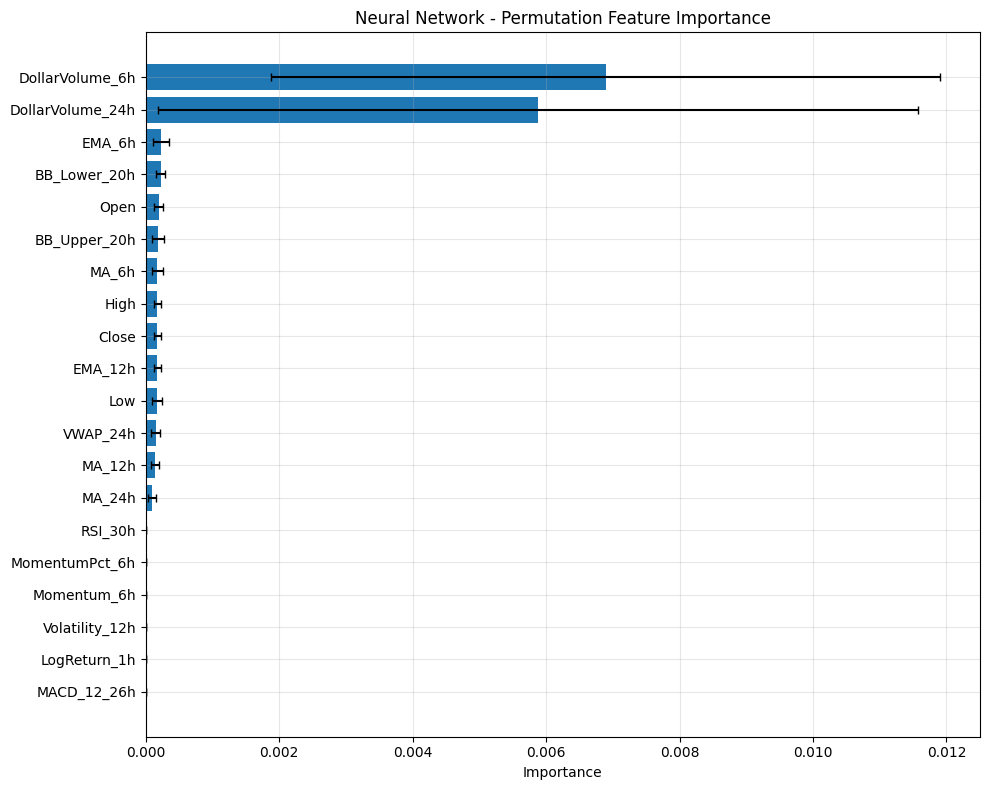

In [45]:
def plot_permutation_importance(model, x, y, model_name="LightGBM", n_features=20):
    """Plot permutation feature importance"""
    perm_importance = permutation_importance(
        model, x, y,
        n_repeats=10,
        random_state=42,
        scoring='roc_auc'
    )

    perm_df = pd.DataFrame({
        'feature': x.columns,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)

    # Plot top features
    plt.figure(figsize=(10, 8))
    top_features = perm_df.head(n_features)

    plt.barh(top_features['feature'], top_features['importance'], xerr=top_features['std'], capsize=3)
    plt.gca().invert_yaxis()
    plt.xlabel('Importance')
    plt.title(f'{model_name} - Permutation Feature Importance')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return perm_df

X_test_perm = X_test[X_train_gs.columns].copy()
X_test_perm.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_perm.dropna(inplace=True)
y_test_perm = y_test.loc[X_test_perm.index]

perm_df = plot_permutation_importance(best_model, X_test_perm, y_test_perm, model_name=best_model_name)


We cluster the top 20 features based on their pairwise correlations using hierarchical clustering. This helps identify redundant features, potential feature groups, or latent patterns that the model may exploit. The heatmap below reveals clusters of correlated predictors, which could guide dimensionality reduction or model simplification.

<Figure size 1200x1000 with 0 Axes>

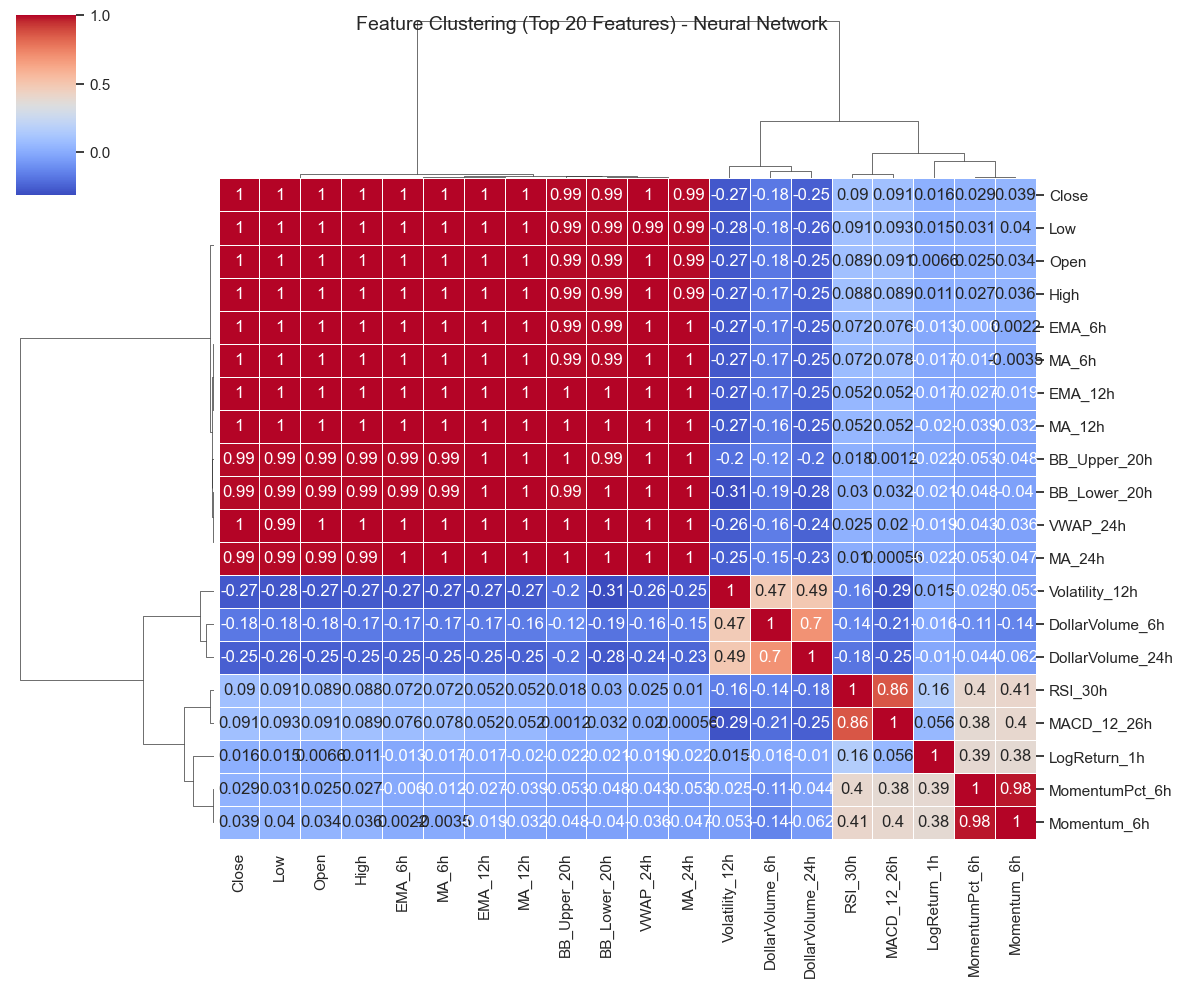

In [46]:
# 1. Compute correlation matrix for top N features from best model
top_features = perm_df.head(20)["feature"].tolist()  # Use perm_df from previous step
X_cluster = X_test[top_features].copy()

# Ensure clean data
X_cluster = X_cluster.select_dtypes(include=[np.number])
X_cluster.replace([np.inf, -np.inf], np.nan, inplace=True)
X_cluster.dropna(inplace=True)

# 2. Plot clustered heatmap
sns.set(style="white")
plt.figure(figsize=(12, 10))
sns.clustermap(
    X_cluster.corr(),
    method='ward',
    cmap='coolwarm',
    linewidths=.5,
    figsize=(12, 10),
    annot=True
)
plt.suptitle(f"Feature Clustering (Top 20 Features) - {best_model_name}", fontsize=14)
plt.show()


We evaluate our final model using standard classification metrics on both the training and test sets. In addition to accuracy, precision, and recall, we compute the F1-score and AUC, which are more appropriate for imbalanced classification tasks. Our final model generalizes well to unseen data and achieves consistent performance across metrics.

In [47]:
# Clean and align feature sets
X_train_eval = X_train.select_dtypes(include=[np.number]).copy()
X_test_eval = X_test.select_dtypes(include=[np.number]).copy()
X_train_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_eval.dropna(inplace=True)
X_test_eval.dropna(inplace=True)

y_train_eval = y_train.loc[X_train_eval.index]
y_test_eval = y_test.loc[X_test_eval.index]

# Predict
y_train_pred = best_model.predict(X_train_eval)
y_test_pred = best_model.predict(X_test_eval)
y_train_proba = best_model.predict_proba(X_train_eval)[:, 1]
y_test_proba = best_model.predict_proba(X_test_eval)[:, 1]

# Collect metrics
metrics = {
    'Train Accuracy': accuracy_score(y_train_eval, y_train_pred),
    'Test Accuracy': accuracy_score(y_test_eval, y_test_pred),
    'Train Precision': precision_score(y_train_eval, y_train_pred),
    'Test Precision': precision_score(y_test_eval, y_test_pred),
    'Train Recall': recall_score(y_train_eval, y_train_pred),
    'Test Recall': recall_score(y_test_eval, y_test_pred),
    'Train F1': f1_score(y_train_eval, y_train_pred),
    'Test F1': f1_score(y_test_eval, y_test_pred),
    'Train AUC': roc_auc_score(y_train_eval, y_train_proba),
    'Test AUC': roc_auc_score(y_test_eval, y_test_proba),
}

# Print summary
print(f"Evaluation Metrics for Best Model ({best_model_name}):")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Evaluation Metrics for Best Model (Neural Network):
Train Accuracy: 0.5230
Test Accuracy: 0.5136
Train Precision: 0.5230
Test Precision: 0.5136
Train Recall: 1.0000
Test Recall: 1.0000
Train F1: 0.6868
Test F1: 0.6786
Train AUC: 0.5051
Test AUC: 0.5050


### Strategy BackTesting

In [48]:
def backtest_strategy(signals: pd.Series, prices: pd.Series, strategy_name="Strategy"):
    """
    Backtest a long/short strategy using binary signals and return performance metrics.

    Parameters:
    - signals: pd.Series of model predictions (1 for long, 0 for short or neutral)
    - prices: pd.Series of close prices aligned with the signal index

    Returns:
    - performance_metrics: dict of key backtesting metrics
    - equity_curve: pd.Series of cumulative returns
    """
    # Align
    signals = signals.loc[signals.index.intersection(prices.index)]
    prices = prices.loc[signals.index]

    # Calculate returns
    returns = prices.pct_change().fillna(0)
    strategy_returns = returns * signals.shift(1).fillna(0)  # Position applied from next bar

    # Equity curve
    equity_curve = (1 + strategy_returns).cumprod()

    # Metrics
    total_return = equity_curve.iloc[-1] - 1
    n_years = (equity_curve.index[-1] - equity_curve.index[0]).days / 365.25
    CAGR = (equity_curve.iloc[-1]) ** (1 / n_years) - 1

    volatility = strategy_returns.std() * np.sqrt(24 * 365)
    sharpe_ratio = CAGR / volatility if volatility != 0 else np.nan

    downside_returns = strategy_returns[strategy_returns < 0]
    sortino_ratio = CAGR / (downside_returns.std() * np.sqrt(24 * 365)) if not downside_returns.empty else np.nan

    rolling_max = equity_curve.cummax()
    drawdown = equity_curve / rolling_max - 1
    max_drawdown = drawdown.min()

    # Average holding period
    trades = signals.diff().fillna(0).abs()
    n_trades = trades.sum()
    holding_period = trades[trades == 1].index.to_series().diff().dt.total_seconds() / 3600
    avg_holding_period = holding_period.mean()

    performance_metrics = {
        "Total Return": total_return,
        "CAGR": CAGR,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
    }

    return performance_metrics, equity_curve


In [51]:
# Attach datetime index from X_test to predicted signals
signals = pd.Series(y_test_pred, index=X_test.index)

# Extract test prices using the same datetime index
test_prices = features["Close"].loc[signals.index]

# Now backtest
performance_metrics, equity_curve = backtest_strategy(signals, test_prices)

# Optional: view performance
print(pd.Series(performance_metrics).round(4))



Total Return                0.6342
CAGR                        0.6370
Volatility                  0.9417
Sharpe Ratio                0.6764
Sortino Ratio               0.8476
Max Drawdown               -0.5476
Avg Holding Period (hrs)       NaN
Number of Trades            0.0000
dtype: float64
